# CNN+LSTM+Transformer encoder (CLT) for proportional muscular fatigue estimation

## Importing libraries and defining global variables

In [ ]:
from google.colab import drive
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import joblib
import time

In [ ]:
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

In [ ]:
EXP_TYPE = 'MULTIPLE' # Options: 'SINGLE', 'MULTIPLE'
FEATURE = 'RAW' # Options: 'RAW', 'MAV', 'RMS', 'MNF'
USER = 'H003B0101' # Options: 'H001B0101', 'H002B0101', 'H003B0101', 'H004B0101', 'H022B0101', 'H023B0101', 'H024B0101', 'H031B0101', 'H032B0101'
LEVEL_TYPE = 'FLOAT' #Options: 'FLOAT', 'INT'

## Data Loading

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
if FEATURE == 'RAW':
  run2 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_2.csv"
  run3 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_3.csv"
  run4 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_4.csv"

elif FEATURE == 'MAV':
  run2 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_2_mav.csv"
  run3 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_3_mav.csv"
  run4 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_4_mav.csv"

elif FEATURE == 'RMS':
  run2 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_2_rms.csv"
  run3 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_3_rms.csv"
  run4 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_4_rms.csv"

elif FEATURE == 'MNF':
  run2 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_2_mnf.csv"
  run3 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_3_mnf.csv"
  run4 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_4_mnf.csv"

In [ ]:
batch_size = 1024

if EXP_TYPE == 'SINGLE':
  hdemg_data = pd.read_csv(run2) # Load data containing HD-EMG signals
  new_columns = [f"Channel {i}" for i in range(1, 65)]
  hdemg_data.columns = new_columns

  if USER == 'H001B0101' or USER == 'H002B0101' or USER == 'H003B0101':
    hdemg_data = hdemg_data.iloc[:-1000] # Remove the last 1000 rows as there is an undesired peak

  # Check if the data length is odd, and remove the odd number of rows to make it divisible by batch size
  original_length = hdemg_data.shape[0]
  odd_data = original_length % batch_size
  hdemg_data = hdemg_data.iloc[:-odd_data]

  # Generate the fatigue levels with linear assumption
  if LEVEL_TYPE == 'FLOAT':
    fatigue_level_synthetic = np.linspace(0, 100, num=hdemg_data.shape[0])
  elif LEVEL_TYPE == 'INT':
    fatigue_level_synthetic = np.linspace(0, 100, num=hdemg_data.shape[0]).astype(int)

# ------------------------------------------------------------------------------

elif EXP_TYPE == 'MULTIPLE':
  # Load data containing HD-EMG signals
  hdemg_data_2 = pd.read_csv(run2)
  hdemg_data_3 = pd.read_csv(run3)
  hdemg_data_4 = pd.read_csv(run4)

  if USER == 'H001B0101' or USER == 'H002B0101' or USER == 'H003B0101':
    # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_2 = hdemg_data_2.iloc[:-1000]
    hdemg_data_3 = hdemg_data_3.iloc[:-1000]
    hdemg_data_4 = hdemg_data_4.iloc[:-1000]

  # Check if the data length is odd, and remove the odd number of rows to make it divisible by batch size
  original_length_2 = hdemg_data_2.shape[0]
  original_length_3 = hdemg_data_3.shape[0]
  original_length_4 = hdemg_data_4.shape[0]

  odd_data_2 = original_length_2 % batch_size
  odd_data_3 = original_length_3 % batch_size
  odd_data_4 = original_length_4 % batch_size

  hdemg_data_2 = hdemg_data_2.iloc[:-odd_data_2]
  hdemg_data_3 = hdemg_data_3.iloc[:-odd_data_3]
  hdemg_data_4 = hdemg_data_4.iloc[:-odd_data_4]

  # Generate the fatigue levels with linear assumption
  if LEVEL_TYPE == 'FLOAT':
    fatigue_level_2 = np.linspace(0, 100, num=hdemg_data_2.shape[0])
    fatigue_level_3 = np.linspace(0, 100, num=hdemg_data_3.shape[0])
    fatigue_level_4 = np.linspace(0, 100, num=hdemg_data_4.shape[0])
  elif LEVEL_TYPE == 'INT':
    fatigue_level_2 = np.linspace(0, 100, num=hdemg_data_2.shape[0]).astype(int)
    fatigue_level_3 = np.linspace(0, 100, num=hdemg_data_3.shape[0]).astype(int)
    fatigue_level_4 = np.linspace(0, 100, num=hdemg_data_4.shape[0]).astype(int)

  # Add columns names, as the original dataframe doesn't have any
  new_columns = [f"Channel {i}" for i in range(1, 65)]
  hdemg_data_2.columns = new_columns
  hdemg_data_3.columns = new_columns
  hdemg_data_4.columns = new_columns

  # Concatenate experiment runs 2 and 3, as it's the train data
  hdemg_data = pd.concat([hdemg_data_2, hdemg_data_3], axis=0)
  fatigue_level_2_df = pd.DataFrame(fatigue_level_2,columns=["Fatigue level"])
  fatigue_level_3_df = pd.DataFrame(fatigue_level_3,columns=["Fatigue level"])
  fatigue_level_synthetic = pd.concat([fatigue_level_2_df, fatigue_level_3_df], axis=0)

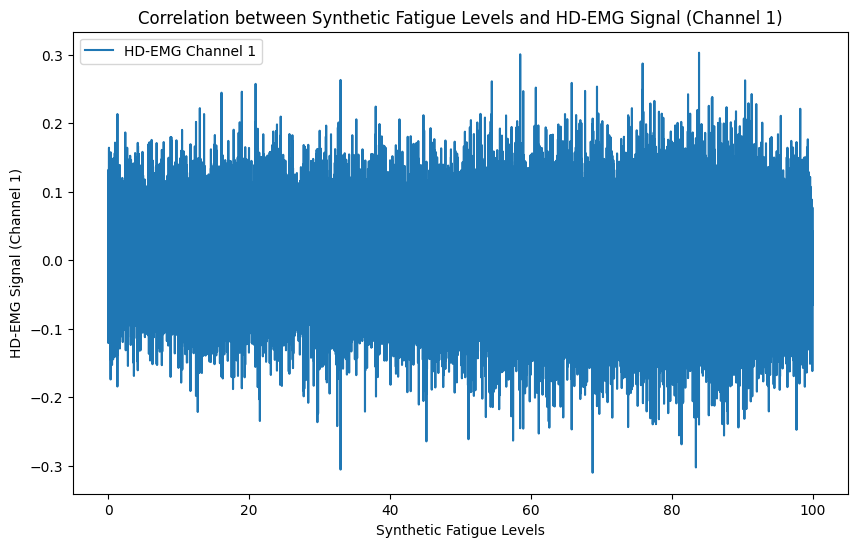

In [ ]:
if EXP_TYPE == 'SINGLE':
  # Define the number of samples and channels
  samples = hdemg_data.shape[0]
  channels = hdemg_data.shape[1]

  # Create synthetic labels for fatigue levels
  yn = np.linspace(0, 100, num=samples)

  # Show HD-EMG signal and fatigue level correlation for a single channal
  plt.figure(figsize=(10, 6))
  plt.plot(fatigue_level_synthetic, hdemg_data.iloc[:, 0], label='HD-EMG Channel 1')
  plt.xlabel('Synthetic Fatigue Levels')
  plt.ylabel('HD-EMG Signal (Channel 1)')
  plt.title('Correlation between Synthetic Fatigue Levels and HD-EMG Signal (Channel 1)')
  plt.legend()
  plt.show()

In [ ]:
#@title Organize data in windows and batches

# Define a custom dataset class
class CustomDataset(Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    # Return a sample from the dataset
    sample = {'data': self.data[idx], 'label': self.labels[idx]}
    return sample

# ------------------------------------------------------------------------------

# Split the data into windows of 1024 values and assign labels indicating the mean fatigue level
window_size = 1024
data_windows = []
label_means = []

for i in range(0, len(hdemg_data) - window_size + 1, window_size):
    window_data = hdemg_data.iloc[i:i+window_size, :] # Extract a window of data
    window_label_mean = np.mean(fatigue_level_synthetic[i:i+window_size]) # Calculate the mean fatigue level for the window
    # Append the window data and label mean to the lists
    data_windows.append(window_data)
    label_means.append(window_label_mean)

# Convert the windowed data and labels to PyTorch tensors (windows converted to numpy arrays for speed)
tensor_data = torch.tensor(np.array([window.values for window in data_windows]))
tensor_labels = torch.tensor(label_means)

# ------------------------------------------------------------------------------

# Define the ratio for data split
if EXP_TYPE == 'SINGLE':
  train_ratio = 0.7
  val_ratio = 0.15
  test_ratio = 0.15
elif EXP_TYPE == 'MULTIPLE':
  train_ratio = 0.8
  val_ratio = 0.1
  test_ratio = 0.1

# Split the data into training, validation, and test sets
train_data, test_val_data, train_labels, test_val_labels = train_test_split(tensor_data, tensor_labels, test_size=val_ratio + test_ratio, random_state=42)
if EXP_TYPE == 'SINGLE':
  val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5, random_state=42)
elif EXP_TYPE == 'MULTIPLE':
  val_data = test_val_data
  val_labels = test_val_labels

  for i in range(0, len(hdemg_data_4) - window_size + 1, window_size):
      window_data = hdemg_data_4.iloc[i:i+window_size, :] # Extract a window of data for experiment run 4
      window_label_mean = np.mean(fatigue_level_4[i:i+window_size]) # Calculate the mean fatigue level for the window
      # Append the window data and label mean to the lists
      data_windows.append(window_data)
      label_means.append(window_label_mean)

  # Convert the windowed data and labels for experiment run 4 to PyTorch tensors (windows converted to numpy arrays for speed)
  test_data = torch.tensor(np.array([window.values for window in data_windows]))
  test_labels = torch.tensor(label_means)

# ------------------------------------------------------------------------------

# Create custom datasets and dataloaders
train_dataset = CustomDataset(train_data, train_labels)
val_dataset = CustomDataset(val_data, val_labels)
test_dataset = CustomDataset(test_data, test_labels)

batch_size = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Model definition

In [ ]:
#@title CNN Module

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convolutions = nn.Sequential(
            # Convolutional block 1
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            # Convolutional block 2
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            # Convolutional block 3
            nn.Conv1d(in_channels=32, out_channels=10, kernel_size=3),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.features = nn.Sequential(
            nn.Linear(10 * 126, 1260),
            nn.Dropout(0.5),
            nn.Linear(1260, 100)
        )

    def forward(self, x):
        x = self.convolutions(x.float())
        x = torch.flatten(x, 1)
        x = self.features(x)
        return x

In [ ]:
#@title LSTM Module

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1024, hidden_size=100, num_layers=2, batch_first=True)
        self.fc = nn.Linear(100, 100)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x.float()) # Retrieve the final hidden state h_n
        x = self.fc(h_n[-1]) # Pass the last hidden state (h_n[-1]) through the fully connected layer
        return x

In [ ]:
#@title Fusion Module

class Fusion(nn.Module):
    def __init__(self):
        super(Fusion, self).__init__()
        self.fc_fusion = nn.Linear(200, 100)  # Fully connected layer to fuse the outputs

    def forward(self, cnn_output, lstm_output):
        # Fuse the outputs of CNN and LSTM by concatenating them
        fused_output = torch.cat((cnn_output, lstm_output), dim=1)

        fused_output = self.fc_fusion(fused_output)

        return fused_output

In [ ]:
#@title Positional Encoding for Transformer encoder Module

class PositionalEncoding(nn.Module):
    def __init__(self, max_len, emb_dim):
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.emb_dim = emb_dim
        # Initialize positional encoding and frequency term
        self.register_buffer('pos', self._get_pos(max_len))
        self.register_buffer('den', self._get_den(emb_dim))

    def _get_pos(self, max_len): # positional encoding
        return torch.arange(max_len).unsqueeze(1)

    def _get_den(self, emb_dim): # frequency term
        return torch.pow(10000, torch.arange(0, emb_dim, 2) / emb_dim)

    def forward(self, x):
        batch_size, seq_len = x.size()
        pe = torch.zeros(batch_size, max_len, emb_dim, device=x.device)
        # Calculate sine and cosine positional encodings
        pe[0, :, 0::2] = torch.sin(self.pos / self.den)
        pe[0, :, 1::2] = torch.cos(self.pos / self.den)

        aux = pe[:, :x.size(1), :]
        x = x + torch.squeeze(aux) # Add positional encoding to input sequence
        return x

In [ ]:
#@title CLT Model

class CLTModel(nn.Module):
    def __init__(self, max_len, emb_dim):
        super(CLTModel, self).__init__()
        self.cnn_model = CNN()
        self.lstm_model = LSTM()
        self.fusion_model = Fusion()
        self.positional_encoding = PositionalEncoding(max_len, emb_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=100, nhead=2, dim_feedforward=100, dropout=0.1, activation="relu", batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.linear = nn.Linear(100, 1)

    def forward(self, x):
        cnn_output = self.cnn_model(x)
        lstm_output = self.lstm_model(x)
        fused_output = self.fusion_model(cnn_output, lstm_output)

        fused_output_with_pe = self.positional_encoding(fused_output)
        encoder_output = self.encoder(fused_output_with_pe)

        linear_output = self.linear(lstm_output.squeeze(dim=1)) # Obtain final single value

        return linear_output

## Model training and evaluation

In [ ]:
class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt', trace_func=print):
    """
    Initialize the EarlyStopping object.

    Args:
        patience (int): Number of epochs to wait before early stopping if no improvement is seen.
        delta (float): Minimum change in monitored quantity to qualify as an improvement.
        verbose (bool): If True, prints a message for each improvement.
        path (str): Path for saving the model checkpoint.
    """
    self.patience = patience
    self.delta = delta
    self.verbose = verbose
    self.path = path
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf

  def __call__(self, val_loss, model):
    """
    Call method to track validation loss and decide whether to early stop.

    Args:
        val_loss (float): Current validation loss.
        model: PyTorch model being trained.
    """
    score = -val_loss # Using negative loss to prioritize higher scores for better performance

    if self.best_score is None:  # If no best score is set yet, initialize it with the current score and save the model checkpoint
        self.best_score = score
        self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta: # If the score does not improve by at least the delta value, increment the counter
        self.counter += 1
        print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
        if self.counter >= self.patience: # If the counter exceeds the patience threshold, update the flag
            self.early_stop = True
    else: # If the score improves, update the best_score, save the model checkpoint, and reset the counter
        self.best_score = score
        self.save_checkpoint(val_loss, model)
        self.counter = 0

  def save_checkpoint(self, val_loss, model):
    """
    Save model checkpoint if validation loss has decreased.

    Args:
        val_loss (float): Current validation loss.
        model: PyTorch model being trained.
    """
    if self.verbose:
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss

In [ ]:
# Initialize early stopping object
early_stopping = EarlyStopping(patience=10, verbose=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define model parameters
emb_dim = 1
max_len = 100

# Instantiate the CLT model and move it to the appropriate device
clt_model = CLTModel(max_len, emb_dim)
clt_model = clt_model.to(device)

# Hyperparameters
lr = 0.001
num_epochs = 1500
eval_steps = 50

criterion = nn.MSELoss()
optimizer = optim.Adam(clt_model.parameters(), lr=lr)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=num_epochs)

train_loss_history = []
val_loss_history = []

# Train the model
start_time = time.time()
clt_model.train()
for epoch in range(num_epochs):
    train_loss = 0.0

    # Iterate over batches in the training data
    for batch_idx, batch in enumerate(train_loader):
        batch_data = batch['data']
        batch_labels = batch['label']

        batch_permuted = batch_data.permute(0, 2, 1)  # From (batch_size, channels, sequence_length) to (batch_size, sequence_length, channels)
        batch_permuted_float = batch_permuted.float()

        batch_labels_expanded = batch_labels.unsqueeze(1) # Expand dimensions of labels tensor to match the output shape of the model
        batch_labels_expanded = batch_labels_expanded.float()

        batch_permuted_float = batch_permuted_float.to(device)
        batch_labels_expanded = batch_labels_expanded.to(device)

        optimizer.zero_grad() # Zero the gradients to clear the previous gradients and compute them again

        output_clt = clt_model(batch_permuted_float)
        train_loss = criterion(output_clt, batch_labels_expanded)
        train_loss_history.append(train_loss)

        train_loss.backward()
        optimizer.step()
        scheduler.step()

    # Evaluate on validation set
    if (epoch + 1) % eval_steps == 0:
      clt_model.eval()
      with torch.no_grad(): # Disable gradient calculation since we are evaluating the model
          val_loss = 0.0
          for val_batch_idx, val_batch in enumerate(val_loader):
              val_batch_data = val_batch['data']
              val_batch_labels = val_batch['label']

              val_batch_permuted_float = val_batch_data.permute(0, 2, 1).float().to(device)
              val_batch_labels_expanded = val_batch_labels.unsqueeze(1).float().to(device)

              val_output_clt = clt_model(val_batch_permuted_float)

              val_loss = criterion(val_output_clt, val_batch_labels_expanded)
              val_loss_history.append(val_loss)

          print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
          clt_model.train() # Set the model back to training mode

      # Check for early stopping
      early_stopping(val_loss, clt_model)
      if early_stopping.early_stop:
          print("Early stopping...")
          break

end_time = time.time()
execution_time = end_time - start_time

minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print("Execution time:", minutes, "minutes", seconds, "seconds")

Epoch [50/1500], Training Loss: 12.9180, Validation Loss: 369.1654
Epoch [100/1500], Training Loss: 56.6189, Validation Loss: 98.7753
Epoch [150/1500], Training Loss: 1.9321, Validation Loss: 223.7466
EarlyStopping counter: 1 out of 10
Epoch [200/1500], Training Loss: 3.8612, Validation Loss: 354.9422
EarlyStopping counter: 2 out of 10
Epoch [250/1500], Training Loss: 5.9591, Validation Loss: 99.8729
EarlyStopping counter: 3 out of 10
Epoch [300/1500], Training Loss: 3.4643, Validation Loss: 557.9810
EarlyStopping counter: 4 out of 10
Epoch [350/1500], Training Loss: 1.0205, Validation Loss: 515.9515
EarlyStopping counter: 5 out of 10
Epoch [400/1500], Training Loss: 6.7320, Validation Loss: 1129.2314
EarlyStopping counter: 6 out of 10
Epoch [450/1500], Training Loss: 1.4368, Validation Loss: 319.7619
EarlyStopping counter: 7 out of 10
Epoch [500/1500], Training Loss: 1.0854, Validation Loss: 207.9751
EarlyStopping counter: 8 out of 10
Epoch [550/1500], Training Loss: 0.4208, Validatio

In [ ]:
# Evaluate on the test set
test_predictions = []
test_targets = []

clt_model.eval()
with torch.no_grad(): # Disable gradient calculation since we are evaluating the model
    for batch_idx, batch in enumerate(test_loader):
        batch_data = batch['data']
        batch_labels = batch['label']

        batch_permuted_float = batch_data.permute(0, 2, 1).float().to(device)

        output_clt = clt_model(batch_permuted_float)

        # Convert predictions and labels to numpy arrays for computing metrics
        test_predictions.extend(output_clt.cpu().numpy())
        test_targets.extend(batch_labels.numpy())

# Evaluate model's performance
r2 = r2_score(test_targets, test_predictions)
pearson_corr, _ = pearsonr(np.array(test_targets).flatten(), np.array(test_predictions).flatten())

# Print the metric's results
print("R^2 Score:", r2)
print("Pearson Correlation Coefficient:", pearson_corr)


R^2 Score: 0.2894916653155314
Pearson Correlation Coefficient: 0.6265443240550684


In [ ]:
#@title K-fold Cross Validation intra-subject (2 experiment runs for training and 1 for testing)

# Redefine in case the previous training wasn't executed
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return sample

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define model parameters
emb_dim = 1
max_len = 100

# Instantiate the CLT model and move it to the appropriate device
clt_model = CLTModel(max_len, emb_dim)
clt_model = clt_model.to(device)

# Hyperparameters
lr = 0.001
num_epochs = 1500
eval_steps = 50

criterion = nn.MSELoss()
optimizer = optim.Adam(clt_model.parameters(), lr=lr)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=num_epochs)

train_loss_history = []
val_loss_history = []

window_size = 1024
batch_size = 10

# Define k-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize list to store cross-validation scores
r2_scores = []
pcorr_values = []

# Perform cross-validation
start_time = time.time()
for train_index, test_index in kf.split([2, 3, 4]):
    early_stopping = EarlyStopping(patience=10, verbose=False)
    print("train: ", train_index+2)
    print("test: ", test_index+2)

    # Select experiments for training and testing
    train_exp = [hdemg_data_2, hdemg_data_3, hdemg_data_4][train_index[0]], [hdemg_data_2, hdemg_data_3, hdemg_data_4][train_index[1]]
    test_exp = [hdemg_data_2, hdemg_data_3, hdemg_data_4][test_index[0]]
    train_fatigue = [fatigue_level_2, fatigue_level_3, fatigue_level_4][train_index[0]], [fatigue_level_2, fatigue_level_3, fatigue_level_4][train_index[1]]
    test_fatigue = [fatigue_level_2, fatigue_level_3, fatigue_level_4][test_index[0]]

    # Combine data for training
    hdemg_data_train = pd.concat(train_exp, axis=0)
    fatigue_level_train = np.concatenate(train_fatigue)

    # Compute the data windows and associated labels
    data_windows = []
    label_means = []

    for i in range(0, len(hdemg_data_train) - window_size + 1, window_size):
      window_data = hdemg_data_train.iloc[i:i+window_size, :]
      window_label_mean = np.mean(fatigue_level_train[i:i+window_size])
      data_windows.append(window_data)
      label_means.append(window_label_mean)

    # Convert to PyTorch tensors
    tensor_data = torch.tensor(np.array([window.values for window in data_windows]))
    tensor_labels = torch.tensor(label_means)

    # Define the train-validation-test split ratios
    train_ratio = 0.8
    val_ratio = 0.1
    test_ratio = 0.1

    # Split into training, validation, and test sets
    train_data, test_val_data, train_labels, test_val_labels = train_test_split(tensor_data, tensor_labels, test_size=val_ratio + test_ratio, random_state=42)

    train_dataset = CustomDataset(train_data, train_labels)
    val_dataset = CustomDataset(test_val_data, test_val_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Organize data from the selected experiment run to be the test_loader
    for i in range(0, len(test_exp) - window_size + 1, window_size):
      window_data = test_exp.iloc[i:i+window_size, :]
      window_label_mean = np.mean(test_fatigue[i:i+window_size])
      data_windows.append(window_data)
      label_means.append(window_label_mean)

    tensor_data = torch.tensor(np.array([window.values for window in data_windows]))
    tensor_labels = torch.tensor(label_means)

    test_dataset = CustomDataset(tensor_data, tensor_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_loss_history = []
    val_loss_history = []

    # Train the model
    clt_model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0

        # Iterate over batches in the training data
        for batch_idx, batch in enumerate(train_loader):
            batch_data = batch['data']
            batch_labels = batch['label']

            batch_permuted = batch_data.permute(0, 2, 1) # From (batch_size, channels, sequence_length) to (batch_size, sequence_length, channels)
            batch_permuted_float = batch_permuted.float()

            batch_labels_expanded = batch_labels.unsqueeze(1)  # Expand dimensions of labels tensor to match the output shape of the model
            batch_labels_expanded = batch_labels_expanded.float()

            batch_permuted_float = batch_permuted_float.to(device)
            batch_labels_expanded = batch_labels_expanded.to(device)

            optimizer.zero_grad() # Zero the gradients to clear the previous gradients and compute them again
            output_clt = clt_model(batch_permuted_float)
            train_loss = criterion(output_clt, batch_labels_expanded)
            train_loss_history.append(train_loss)

            train_loss.backward()
            optimizer.step()
            scheduler.step()

        # Evaluate on validation set
        if (epoch + 1) % eval_steps == 0:
          clt_model.eval()
          with torch.no_grad(): # Disable gradient calculation since we are evaluating the model
              val_loss = 0.0
              for val_batch_idx, val_batch in enumerate(val_loader):
                  val_batch_data = val_batch['data']
                  val_batch_labels = val_batch['label']

                  val_batch_permuted_float = val_batch_data.permute(0, 2, 1).float().to(device)
                  val_batch_labels_expanded = val_batch_labels.unsqueeze(1).float().to(device)

                  val_output_clt = clt_model(val_batch_permuted_float)

                  val_loss = criterion(val_output_clt, val_batch_labels_expanded)
                  val_loss_history.append(val_loss)

              print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
              clt_model.train() # Set the model back to training mode

          # Check for early stopping
          early_stopping(val_loss, clt_model)
          if early_stopping.early_stop:
              print("Early stopping...")
              break

    # Evaluate on the test set
    test_predictions = []
    test_targets = []

    clt_model.eval()
    with torch.no_grad(): # Disable gradient calculation since we are evaluating the model
        for batch_idx, batch in enumerate(test_loader):
            batch_data = batch['data']
            batch_labels = batch['label']

            batch_permuted_float = batch_data.permute(0, 2, 1).float().to(device)

            output_clt = clt_model(batch_permuted_float)

            # Convert predictions and labels to numpy arrays for computing metrics
            test_predictions.extend(output_clt.cpu().numpy())
            test_targets.extend(batch_labels.numpy())

    # Evaluate model's performance
    r2 = r2_score(test_targets, test_predictions)
    r2_scores.append(r2)
    pearson_corr, _ = pearsonr(np.array(test_targets).flatten(), np.array(test_predictions).flatten())
    pcorr_values.append(pearson_corr)

end_time = time.time()
execution_time = end_time - start_time

minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print("Execution time:", minutes, "minutes", seconds, "seconds")

# Print cross-validation scores and correlation coefficients
print("R^2 scores:", r2_scores)
print("Average R^2 score:", np.mean(r2_scores))
print("Pearson Correlation Coefficient values:", pcorr_values)
print("Average Pearson Correlation Coefficient value:", np.mean(pcorr_values))

train:  [3 4]
test:  [2]
Epoch [50/1500], Training Loss: 361.7798, Validation Loss: 1016.2919
Epoch [100/1500], Training Loss: 120.7257, Validation Loss: 1001.2665
Epoch [150/1500], Training Loss: 102.1808, Validation Loss: 633.3013
Epoch [200/1500], Training Loss: 80.4503, Validation Loss: 601.3674
Epoch [250/1500], Training Loss: 70.8927, Validation Loss: 564.8361
Epoch [300/1500], Training Loss: 98.8164, Validation Loss: 841.1630
EarlyStopping counter: 1 out of 10
Epoch [350/1500], Training Loss: 65.7338, Validation Loss: 626.7881
EarlyStopping counter: 2 out of 10
Epoch [400/1500], Training Loss: 72.7508, Validation Loss: 605.9453
EarlyStopping counter: 3 out of 10
Epoch [450/1500], Training Loss: 69.9298, Validation Loss: 783.9584
EarlyStopping counter: 4 out of 10
Epoch [500/1500], Training Loss: 56.9846, Validation Loss: 694.1062
EarlyStopping counter: 5 out of 10
Epoch [550/1500], Training Loss: 142.8105, Validation Loss: 479.5786
Epoch [600/1500], Training Loss: 62.8263, Valid

In [ ]:
#@title K-fold Cross Validation intra-subject (All experiment runs combined)

# Redefine in case the previous training wasn't executed
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return sample

# Define model parameters
emb_dim = 1
max_len = 100

# Instantiate the CLT model and move it to the appropriate device
clt_model = CLTModel(max_len, emb_dim)
clt_model = clt_model.to(device)

# Hyperparameters
lr = 0.001
num_epochs = 1500
eval_steps = 50

criterion = nn.MSELoss()
optimizer = optim.Adam(clt_model.parameters(), lr=lr)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=num_epochs)

train_loss_history = []
val_loss_history = []

window_size = 1024
batch_size = 10

# Define k-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize list to store cross-validation scores
r2_scores = []
pcorr_values = []

# Concatenate the data and fatigue levels
hdemg_data_combined = pd.concat([hdemg_data_2, hdemg_data_3, hdemg_data_4], axis=0)
fatigue_level_combined = np.concatenate([fatigue_level_2, fatigue_level_3, fatigue_level_4])

# Compute the data windows and associated labels
data_windows = []
label_means = []
for i in range(0, len(hdemg_data_combined) - window_size + 1, window_size):
    window_data = hdemg_data_combined.iloc[i:i+window_size, :]
    window_label_mean = np.mean(fatigue_level_combined[i:i+window_size])
    data_windows.append(window_data)
    label_means.append(window_label_mean)

# Convert to PyTorch tensors
tensor_data = torch.tensor(np.array([window.values for window in data_windows]))
tensor_labels = torch.tensor(label_means)

fold = 0
# Perform cross-validation
start_time = time.time()
for train_index, test_index in kf.split(tensor_data):
  fold += 1
  print(f"Fold: {fold}")
  early_stopping = EarlyStopping(patience=10, verbose=False)

  # Split data into training and testing sets
  X_train, test_data = tensor_data[train_index], tensor_data[test_index]
  y_train, test_labels = tensor_labels[train_index], tensor_labels[test_index]

  # Obtain the train and validation sets
  train_data, val_data, train_labels, val_labels = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

  # Prepare data sets and data loaders
  train_dataset = CustomDataset(train_data, train_labels)
  val_dataset = CustomDataset(val_data, val_labels)
  test_dataset = CustomDataset(test_data, test_labels)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  train_loss_history = []
  val_loss_history = []

  # Train the model
  clt_model.train()
  for epoch in range(num_epochs):
      train_loss = 0.0

      # Iterate over batches in the training data
      for batch_idx, batch in enumerate(train_loader):
          batch_data = batch['data']
          batch_labels = batch['label']

          batch_permuted = batch_data.permute(0, 2, 1)  # From (batch_size, channels, sequence_length) to (batch_size, sequence_length, channels)
          batch_permuted_float = batch_permuted.float()
          batch_permuted_float = batch_permuted.float()

          batch_labels_expanded = batch_labels.unsqueeze(1)  # Expand dimensions of labels tensor to match the output shape of the model
          batch_labels_expanded = batch_labels_expanded.float()

          batch_permuted_float = batch_permuted_float.to(device)
          batch_labels_expanded = batch_labels_expanded.to(device)

          optimizer.zero_grad() # Zero the gradients to clear the previous gradients and compute them again

          output_clt = clt_model(batch_permuted_float)
          train_loss = criterion(output_clt, batch_labels_expanded)
          train_loss_history.append(train_loss)

          train_loss.backward()
          optimizer.step()
          scheduler.step()

      # Evaluate on validation set
      if (epoch + 1) % eval_steps == 0:
        clt_model.eval()
        with torch.no_grad(): # Disable gradient calculation since we are evaluating the model
            val_loss = 0.0
            for val_batch_idx, val_batch in enumerate(val_loader):
                val_batch_data = val_batch['data']
                val_batch_labels = val_batch['label']

                val_batch_permuted_float = val_batch_data.permute(0, 2, 1).float().to(device)
                val_batch_labels_expanded = val_batch_labels.unsqueeze(1).float().to(device)

                val_output_clt = clt_model(val_batch_permuted_float)

                val_loss = criterion(val_output_clt, val_batch_labels_expanded)
                val_loss_history.append(val_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            clt_model.train() # Set the model back to training mode

        # Check for early stopping
        early_stopping(val_loss, clt_model)
        if early_stopping.early_stop:
            print("Early stopping...")
            break

  # Evaluate on the test set
  test_predictions = []
  test_targets = []

  clt_model.eval()
  with torch.no_grad(): # Disable gradient calculation since we are evaluating the model
      for batch_idx, batch in enumerate(test_loader):
          batch_data = batch['data']
          batch_labels = batch['label']

          batch_permuted_float = batch_data.permute(0, 2, 1).float().to(device)

          output_clt = clt_model(batch_permuted_float)

          # Convert predictions and labels to numpy arrays for computing metrics
          test_predictions.extend(output_clt.cpu().numpy())
          test_targets.extend(batch_labels.numpy())

  # Evaluate model's performance
  r2 = r2_score(test_targets, test_predictions)
  r2_scores.append(r2)
  pearson_corr, _ = pearsonr(np.array(test_targets).flatten(), np.array(test_predictions).flatten())
  pcorr_values.append(pearson_corr)

end_time = time.time()
execution_time = end_time - start_time

minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print("Execution time:", minutes, "minutes", seconds, "seconds")

# Print cross-validation scores and correlation coefficients
print("R^2 scores:", r2_scores)
print("Average R^2 score:", np.mean(r2_scores))
print("Pearson Correlation Coefficient values:", pcorr_values)
print("Average Pearson Correlation Coefficient value:", np.mean(pcorr_values))


Fold: 1
Epoch [50/1500], Training Loss: 139.3909, Validation Loss: 134.0843
Epoch [100/1500], Training Loss: 99.8092, Validation Loss: 354.1743
EarlyStopping counter: 1 out of 10
Epoch [150/1500], Training Loss: 640.0422, Validation Loss: 103.7609
Epoch [200/1500], Training Loss: 200.1536, Validation Loss: 84.9873
Epoch [250/1500], Training Loss: 157.0127, Validation Loss: 71.3361
Epoch [300/1500], Training Loss: 128.7761, Validation Loss: 55.7601
Epoch [350/1500], Training Loss: 463.0342, Validation Loss: 132.9237
EarlyStopping counter: 1 out of 10
Epoch [400/1500], Training Loss: 173.7146, Validation Loss: 72.3207
EarlyStopping counter: 2 out of 10
Epoch [450/1500], Training Loss: 210.5563, Validation Loss: 126.3644
EarlyStopping counter: 3 out of 10
Epoch [500/1500], Training Loss: 526.0362, Validation Loss: 56.0304
EarlyStopping counter: 4 out of 10
Epoch [550/1500], Training Loss: 128.0627, Validation Loss: 131.2936
EarlyStopping counter: 5 out of 10
Epoch [600/1500], Training Los

In [ ]:
#@title K-fold Cross Validation with all the subjects

# List with all the subject's names
file_names = [
    "H001B0101", "H002B0101", "H003B0101", "H004B0101", "H022B0101", "H023B0101",
    "H024B0101", "H031B0101", "H032B0101"
]

# DataFrame to store all the data
hdemg_data_combined = pd.DataFrame()
# Array to store the fatigue levels
fatigue_level_combined = np.array([])

for file_name in file_names:
    print(f"Cargando usuario {file_name}")
    # Build file path for every subject
    file_path_base = "/content/drive/MyDrive/HDEMG/"
    new_columns = [f"Channel {i}" for i in range(1, 65)]

    # Read and process data for experiment run 2 -------------------------------
    file_path = f"{file_path_base}/{file_name}/emg_experiment_2_mav.csv"
    hdemg_data_2 = pd.read_csv(file_path)
    if file_name == "H001B0101" or file_name == "H002B0101" or file_name == "H003B0101":
      hdemg_data_2 = hdemg_data_2.iloc[:-1000] # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_2.columns = new_columns
    fatigue_level_2 = np.linspace(0, 100, num=hdemg_data_2.shape[0])

    # Read and process data for experiment run 3 -------------------------------
    file_path = f"{file_path_base}/{file_name}/emg_experiment_3_mav.csv"
    hdemg_data_3 = pd.read_csv(file_path)
    if file_name == "H001B0101" or file_name == "H002B0101" or file_name == "H003B0101":
      hdemg_data_3 = hdemg_data_3.iloc[:-1000] # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_3.columns = new_columns
    fatigue_level_3 = np.linspace(0, 100, num=hdemg_data_3.shape[0])

    # Read and process data for experiment run 4 -------------------------------
    file_path = f"{file_path_base}/{file_name}/emg_experiment_4_mav.csv"
    hdemg_data_4 = pd.read_csv(file_path)
    if file_name == "H001B0101" or file_name == "H002B0101" or file_name == "H003B0101":
      hdemg_data_4 = hdemg_data_4.iloc[:-1000] # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_4.columns = new_columns
    fatigue_level_4 = np.linspace(0, 100, num=hdemg_data_4.shape[0])

    # Concatenate data from all experiment runs for the current subject
    hdemg_data_subject_combined = pd.concat([hdemg_data_2, hdemg_data_3, hdemg_data_4], axis=0)
    fatigue_level_subject_combined = np.concatenate([fatigue_level_2, fatigue_level_3, fatigue_level_4])

    # Concatenate data and fatigue levels for all subjects
    hdemg_data_combined = pd.concat([hdemg_data_combined, hdemg_data_subject_combined], axis=0)
    fatigue_level_combined = np.concatenate([fatigue_level_combined, fatigue_level_subject_combined])

# Redefine in case the previous training wasn't executed
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return sample

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define model parameters
emb_dim = 1
max_len = 100

# Instantiate the CLT model and move it to the appropriate device
clt_model = CLTModel(max_len, emb_dim)
clt_model = clt_model.to(device)

# Hyperparameters
lr = 0.001
num_epochs = 1500
eval_steps = 50

criterion = nn.MSELoss()
optimizer = optim.Adam(clt_model.parameters(), lr=lr)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=num_epochs)

train_loss_history = []
val_loss_history = []

window_size = 1024
batch_size = 10

# Define k-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize list to store cross-validation scores
r2_scores = []
pcorr_values = []

# Compute the data windows and associated labels
data_windows = []
label_means = []
for i in range(0, len(hdemg_data_combined) - window_size + 1, window_size):
    window_data = hdemg_data_combined.iloc[i:i+window_size, :]
    window_label_mean = np.mean(fatigue_level_combined[i:i+window_size])
    data_windows.append(window_data)
    label_means.append(window_label_mean)

# Convert to PyTorch tensors
tensor_data = torch.tensor(np.array([window.values for window in data_windows]))
tensor_labels = torch.tensor(label_means)

fold = 0
# Perform cross-validation
for train_index, test_index in kf.split(tensor_data):
  fold += 1
  print(f"Fold: {fold}")
  early_stopping = EarlyStopping(patience=10, verbose=False)

  # Split data into training and testing sets
  X_train, test_data = tensor_data[train_index], tensor_data[test_index]
  y_train, test_labels = tensor_labels[train_index], tensor_labels[test_index]

  # Obtain the train and validation sets
  train_data, val_data, train_labels, val_labels = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

  # Prepare data sets and data loaders
  train_dataset = CustomDataset(train_data, train_labels)
  val_dataset = CustomDataset(val_data, val_labels)
  test_dataset = CustomDataset(test_data, test_labels)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  train_loss_history = []
  val_loss_history = []

  # Train the model
  clt_model.train()
  for epoch in range(num_epochs):
      train_loss = 0.0

      # Iterate over batches in the training data
      for batch_idx, batch in enumerate(train_loader):
          batch_data = batch['data']
          batch_labels = batch['label']

          #batch_tensor = torch.stack(batch_data, dim=0)
          batch_permuted = batch_data.permute(0, 2, 1)  # From (batch_size, channels, sequence_length) to (batch_size, sequence_length, channels)
          batch_permuted_float = batch_permuted.float()

          batch_labels_expanded = batch_labels.unsqueeze(1)  # Expand dimensions of labels tensor to match the output shape of the model
          batch_labels_expanded = batch_labels_expanded.float()

          batch_permuted_float = batch_permuted_float.to(device)
          batch_labels_expanded = batch_labels_expanded.to(device)


          optimizer.zero_grad() # Zero the gradients to clear the previous gradients and compute them again

          output_clt = clt_model(batch_permuted_float)
          train_loss = criterion(output_clt, batch_labels_expanded)
          train_loss_history.append(train_loss)

          train_loss.backward()
          optimizer.step()
          scheduler.step()

      # Evaluate on validation set
      if (epoch + 1) % eval_steps == 0:
        clt_model.eval()
        with torch.no_grad(): # Disable gradient calculation since we are evaluating the model
            val_loss = 0.0
            for val_batch_idx, val_batch in enumerate(val_loader):
                val_batch_data = val_batch['data']
                val_batch_labels = val_batch['label']

                val_batch_permuted_float = val_batch_data.permute(0, 2, 1).float().to(device)
                val_batch_labels_expanded = val_batch_labels.unsqueeze(1).float().to(device)

                val_output_clt = clt_model(val_batch_permuted_float)

                val_loss = criterion(val_output_clt, val_batch_labels_expanded)
                val_loss_history.append(val_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            clt_model.train() # Set the model back to training mode

        # Check for early stopping
        early_stopping(val_loss, clt_model)
        if early_stopping.early_stop:
            print("Early stopping...")
            break

  # Evaluate on the test set
  test_predictions = []
  test_targets = []

  clt_model.eval()
  with torch.no_grad(): # Disable gradient calculation since we are evaluating the model
      for batch_idx, batch in enumerate(test_loader):
          batch_data = batch['data']
          batch_labels = batch['label']

          batch_permuted_float = batch_data.permute(0, 2, 1).float().to(device)

          output_clt = clt_model(batch_permuted_float)

          # Convert predictions and labels to numpy arrays for computing metrics
          test_predictions.extend(output_clt.cpu().numpy())
          test_targets.extend(batch_labels.numpy())

  # Evaluate model's performance
  r2 = r2_score(test_targets, test_predictions)
  r2_scores.append(r2)
  pearson_corr, _ = pearsonr(np.array(test_targets).flatten(), np.array(test_predictions).flatten())
  pcorr_values.append(pearson_corr)

# Print cross-validation scores and correlation coefficients
print("R^2 scores:", r2_scores)
print("Average R^2 score:", np.mean(r2_scores))
print("Pearson Correlation Coefficient values:", pcorr_values)
print("Average Pearson Correlation Coefficient value:", np.mean(pcorr_values))

Cargando usuario H001B0101
Cargando usuario H002B0101
Cargando usuario H003B0101
Cargando usuario H004B0101
Cargando usuario H022B0101
Cargando usuario H023B0101
Cargando usuario H024B0101
Cargando usuario H031B0101
Cargando usuario H032B0101
Fold: 1
Epoch [50/1500], Training Loss: 135.9732, Validation Loss: 824.6871
Epoch [100/1500], Training Loss: 495.3987, Validation Loss: 444.3115
Epoch [150/1500], Training Loss: 91.1505, Validation Loss: 387.6342
Epoch [200/1500], Training Loss: 127.7412, Validation Loss: 415.3411
EarlyStopping counter: 1 out of 10
Epoch [250/1500], Training Loss: 74.8096, Validation Loss: 235.7722
Epoch [300/1500], Training Loss: 150.2599, Validation Loss: 210.2451
Epoch [350/1500], Training Loss: 224.9032, Validation Loss: 1001.7477
EarlyStopping counter: 1 out of 10
Epoch [400/1500], Training Loss: 36.8865, Validation Loss: 334.4243
EarlyStopping counter: 2 out of 10
Epoch [450/1500], Training Loss: 74.1408, Validation Loss: 175.5309
Epoch [500/1500], Training 

## Plotting results and saving the model

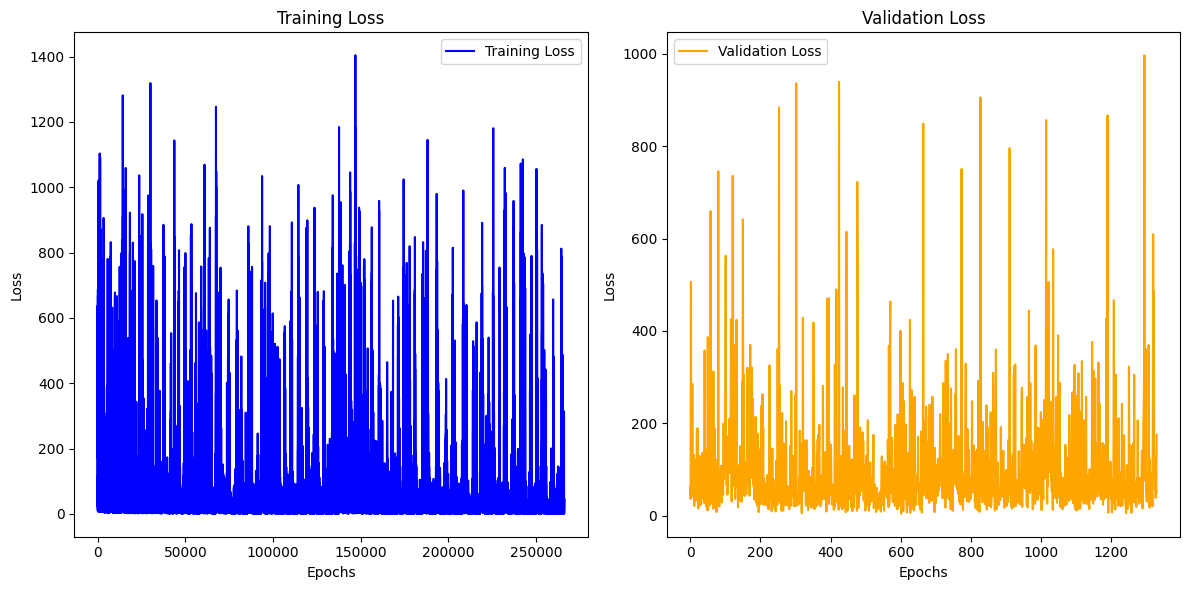

In [ ]:
# Convert loss_history to a list of NumPy arrays on CPU
train_loss_history_cpu = [loss.item() for loss in train_loss_history]
val_loss_history_cpu = [loss.item() for loss in val_loss_history]
train_loss_array = np.asarray(train_loss_history_cpu)
val_loss_array = np.asarray(val_loss_history_cpu)

# Create a new figure
plt.figure(figsize=(12, 6))

# Subfigure for training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_array, label='Training Loss', color='blue')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Subfigure for validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss_array, label='Validation Loss', color='orange')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()  # Automatically adjusts spacing between subfigures
plt.show()

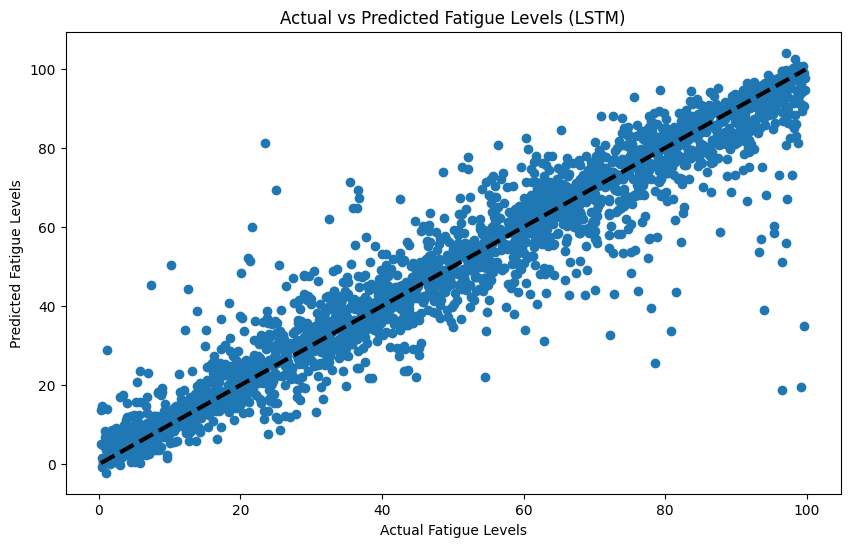

In [ ]:
# Convertir las predicciones y etiquetas de test a numpy arrays para visualización
y_test_cpu = np.array(test_targets)  # Convertir las etiquetas de test a un array de numpy
outputs_cpu = np.array(test_predictions)  # Convertir las predicciones a un array de numpy

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_cpu, outputs_cpu)
plt.plot([y_test_cpu.min(), y_test_cpu.max()], [y_test_cpu.min(), y_test_cpu.max()], 'k--', lw=3)
plt.xlabel('Actual Fatigue Levels')
plt.ylabel('Predicted Fatigue Levels')
plt.title('Actual vs Predicted Fatigue Levels (LSTM)')
plt.show()

In [ ]:
# Save the trained model
joblib.dump(clt_model, 'CLT_model.pkl')

['CLT_model.pkl']